In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from Constants import Constants
#import seaborn as sns
#import time
import athena_read as ar
from scipy.interpolate import RegularGridInterpolator
import pyshtools
import glob
import deepdish as dd
import pygyre as pg


c=Constants()

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.facecolor'] = 'white'


Constants defined...


# Setup

In [52]:
base_dir = "/Volumes/LaCie/turb/P5r/"
hst = ascii.read(base_dir+"tcc.hst",header_start=1)

#plt.plot(hst['[1]=time'],hst['[26]=Etot_r'])
print( hst.keys() )

bg = pg.read_output("gyre/summary.txt")

bg['P_d'] = 2*np.pi/np.real(bg['omega']) * np.sqrt(bg['R_star']**3/(c.G*bg['M_star'])) / 86400.

print( bg[['l','n_pg','P_d']][bg['n_pg']<=1] )

mstar = bg['M_star'][0]
rstar = bg['R_star'][0]

print(mstar/c.msun,rstar/c.rsun)

rph = 8
MSCALE = mstar/hst['[22]=M_r'][0]
RSCALE = rstar/rph
TSCALE = np.sqrt(rstar**3/(c.G*mstar))/np.sqrt(rph**3/1)

print(MSCALE,RSCALE,TSCALE)

['[1]=time', '[2]=dt', '[3]=mass', '[4]=1-mom', '[5]=2-mom', '[6]=3-mom', '[7]=1-KE', '[8]=2-KE', '[9]=3-KE', '[10]=tot-E', '[11]=jx-tot', '[12]=jy-tot', '[13]=jz-tot', '[14]=mdot-1', '[15]=jxdot-1', '[16]=jydot-1', '[17]=jzdot-1', '[18]=mdot-2', '[19]=jxdot-2', '[20]=jydot-2', '[21]=jzdot-2', '[22]=M_r', '[23]=Ek_r', '[24]=Eth_r', '[25]=Eg_r', '[26]=Etot_r']
 l  n_pg        P_d        
--- ---- ------------------
  0    1 410.37440045908914
17.579196195139186 770.8312239882922
3.7582197147616902e+22 6701413953548.216 359120.0634245879


slicing at x3= -0.0390625
0.0
208093046.88786224 0.00043075352346979965
scaled Ein =  2.723286220644024e+45
scaled Eth =  6.322144967515174e+48
24775774.537636723
L/Lsun =  235121.34975717432


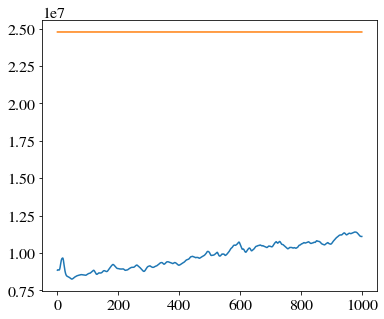

In [53]:
mylevel = 1
db = ar.athdf(base_dir+"tcc.out2.00000.athdf",
              level=mylevel,quantities=[])
x3sliceval=db['x3v'][np.argmin(np.abs(db['x3v']-0))]
print("slicing at x3=",x3sliceval)
d=ar.athdf(base_dir+"tcc.out2.00000.athdf",level=mylevel,
         #x3_min=x3sliceval,x3_max=x3sliceval,
           x1_min=-8,x1_max=8,
           x2_min=-8,x2_max=8,
           x3_min=-8,x3_max=8,
           subsample=True)

d['gx1v']=np.broadcast_to(d['x1v'],(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )
d['gx2v']=np.swapaxes(np.broadcast_to(d['x2v'],(len(d['x3v']),len(d['x1v']),len(d['x2v'])) ),1,2)
d['gx3v']=np.swapaxes(np.broadcast_to(d['x3v'],(len(d['x1v']),len(d['x2v']),len(d['x3v'])) ) ,0,2 )

gamma = 1.4762
d['vmag'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)
d['cs'] = np.sqrt(gamma*d['press']/d['rho'])
d['mach'] = d['vmag']/d['cs']
dv = (d['x1v'][1]-d['x1v'][0])*(d['x2v'][1]-d['x2v'][0])*(d['x3v'][1]-d['x3v'][0])
d['vr'] = (d['vel1']*d['gx1v'] + d['vel2']*d['gx2v'] + d['vel3']*d['gx3v'])/np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)
d['r'] = np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)

d['dp'] = np.sqrt((d['gx1v']-3)**2 + d['gx2v']**2 + d['gx3v']**2)


print(d['Time'])


selr = d['r'] < 8
Ethr = np.sum(d['press'][selr]/(gamma-1)*dv)

#integral of 4pi r^2 exp( - 0.5*r^2/0.25^2), r=0-3
gauss_vol = 0.246
Ein = np.mean(d['press'][d['dp']<0.25])/(gamma-1)*gauss_vol

print(Ein, Ein/Ethr)

print("scaled Ein = ",Ein*MSCALE*RSCALE**2/TSCALE**2)
print("scaled Eth = ",Ethr*MSCALE*RSCALE**2/TSCALE**2)

cd = ascii.read(base_dir+"cooling.dat")
plt.plot(cd['time'],-cd['E-MINUS-INNER']/cd['dt'])
plt.plot(cd['time'],cd['E-PLUS']/cd['dt'])

Lmodel = np.mean(-cd['E-MINUS-INNER']/cd['dt'])
LmodelEplus = np.mean(cd['E-PLUS']/cd['dt'])

print(LmodelEplus)
print("L/Lsun = ", LmodelEplus*MSCALE*RSCALE**2 / TSCALE**3/3.84e33)

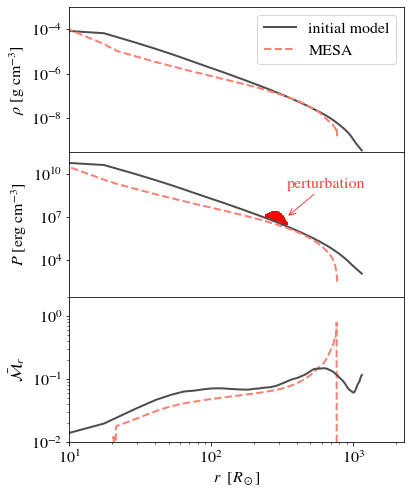

In [54]:
rf = np.linspace(0,12,100)
rc = 0.5*(rf[1:]+rf[:-1])
mach_r = np.zeros_like(rc)
rho_r = np.zeros_like(rc)
press_r = np.zeros_like(rc)

for i in range(len(rc)):
    sel = (d['r']>rf[i]) & (d['r']<=rf[i+1])
    mach_r[i] = np.sum(np.sqrt(d['vr'][sel]**2)/d['cs'][sel]*d['rho'][sel]*dv)/np.sum(d['rho'][sel]*dv)
    rho_r[i]  = np.sum(d['rho'][sel]*dv)/np.sum(np.ones_like(d['rho'][sel])*dv)
    press_r[i]  = np.sum(d['press'][sel]*dv)/np.sum(np.ones_like(d['rho'][sel])*dv)

import mesa_reader as mr


# load the profile file into a MesaData instance
p = ascii.read('profile32.data',header_start=4)


plt.figure(figsize=(6,8))
plt.subplot(311)
#plt.scatter(np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)*RSCALE/c.rsun, 
#            d['rho']*MSCALE/RSCALE**3,s=3,color='0.3',rasterized=True,label='initial model')
plt.plot(rc*RSCALE/c.rsun,rho_r*MSCALE/RSCALE**3,color='0.3',label='initial model',lw=2)
plt.plot(10**p['logR'],10**p['logRho'],color='Salmon',label='MESA',ls='--',lw=2)
plt.loglog()
plt.ylim(3.e-10,1e-3)
plt.xlim(10,)
plt.xticks(visible=False)
plt.legend()
plt.ylabel(r'$\rho$ [g cm$^{-3}$]')

plt.subplot(312)
#plt.scatter(d['r']*RSCALE/c.rsun,d['press']*MSCALE*RSCALE**-1*TSCALE**-2,s=3,
#            color='0.3',label='',rasterized=True)
plt.plot(rc*RSCALE/c.rsun,press_r*MSCALE*RSCALE**-1*TSCALE**-2,color='0.3',label='',lw=2)
plt.scatter(d['r'][d['dp']<0.5]*RSCALE/c.rsun,d['press'][d['dp']<0.5]*MSCALE*RSCALE**-1*TSCALE**-2,s=3,
            color='r',rasterized=True)
plt.plot(10**p['logR'],10**p['logP'],color='Salmon',ls='--',lw=2,label='')
plt.loglog()
plt.ylim(3e1,3e11)
plt.xlim(10,)
plt.xticks(visible=False)
plt.ylabel(r'$P$ [erg cm$^{-3}$]')
plt.annotate('perturbation',xy=(340,1e7),xytext=(340,1e9),color='red',alpha=0.75,
             arrowprops={'arrowstyle': '->', 'lw': 1, 'color': 'red','alpha':0.75})
#plt.legend()

plt.subplot(313)
plt.loglog(10**p['logR'],p['conv_vel_div_csound'],color='Salmon',label='MESA',ls='--',lw=2)
plt.plot(rc*RSCALE/c.rsun,mach_r,color='0.3',lw=2)
plt.xlim(10,)
plt.ylim(0.01,2)
plt.ylabel(r'$\bar{\cal M}_r$')

plt.subplots_adjust(hspace=0)

plt.xlabel('$r\ \  [R_\odot]$')
plt.savefig("figs/ic.pdf",bbox_inches='tight')

In [426]:
### EXTRACT r=const SPHERICAL SURFACES AND SAVE
## NOTE: this step has already been completed, saving the code here for context

base_dir = "/Volumes/LaCie/turb/P5r/"

filelist= glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9].athdf")[::1]
print(filelist)

radlist = [8]

level=1
nt = 200

for i,myfile in enumerate(filelist):
    print(myfile)

    d=ar.athdf(myfile,level=level,
               x1_min=-1.1*radlist[-1],x1_max=1.1*radlist[-1],
               x2_min=-1.1*radlist[-1],x2_max=1.1*radlist[-1],
               x3_min=-1.1*radlist[-1],x3_max=1.1*radlist[-1],
               subsample=True)

    d['gx1v']=np.broadcast_to(d['x1v'],(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )
    d['gx2v']=np.swapaxes(np.broadcast_to(d['x2v'],(len(d['x3v']),len(d['x1v']),len(d['x2v'])) ),1,2)
    d['gx3v']=np.swapaxes(np.broadcast_to(d['x3v'],(len(d['x1v']),len(d['x2v']),len(d['x3v'])) ) ,0,2 )
 
    d['vr'] = (  d['vel1']*d['gx1v'] 
               + d['vel2']*d['gx2v'] 
               + d['vel3']*d['gx3v'])/np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)
    
    vr_interp = RegularGridInterpolator((d['x3v'],d['x2v'],d['x1v']),d['vr'],bounds_error=False,method='linear')
   
    for j,rad in enumerate(radlist):
        th = np.linspace(0,np.pi,nt)
        ph = np.linspace(-np.pi,np.pi,2*nt)

        TT,PP = np.meshgrid(th,ph)
        XX = rad*np.sin(TT)*np.cos(PP)
        YY = rad*np.sin(TT)*np.sin(PP)
        ZZ = rad*np.cos(TT)



        vrsurf = vr_interp((ZZ,YY,XX))

        LAT =  np.pi/2 - TT
        LONG = PP

        dr = {'time':d['Time'],'theta':TT,'phi':PP,'x':XX,'y':YY,'z':ZZ,'vr':vrsurf}
        dd.io.save(myfile[:-6]+'_slice_r'+str(int(rad))+'.hdf5',dr)


['/Volumes/LaCie/turb/P5r/tcc.out2.00000.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00001.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00002.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00003.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00004.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00005.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00006.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00007.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00008.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00009.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00010.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00011.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00012.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00013.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00014.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00015.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00016.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00017.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00018.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00019.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00020

/Volumes/LaCie/turb/P5r/tcc.out2.00075.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00076.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00077.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00078.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00079.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00080.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00081.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00082.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00083.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00084.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00085.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00086.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00087.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00088.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00089.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00090.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00091.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00092.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00093.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00094.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00095.athdf
/Volumes/LaCie/turb/P5r/tcc.out2.00096.athdf
/Volumes/L

In [22]:
### EXTRACT AND SAVE RAYS ALONG X-AXIS
## NOTE: this step has already been completed, saving the code here for context

base_dir = "/Volumes/LaCie/turb/P5r/"

filelist= glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9].athdf")[0:31:1]
print(filelist)
level=1
rad = 10

spectime = []
times = []

mylevel = 1
db = ar.athdf("/Volumes/LaCie/turb/P5r/tcc.out2.00000.athdf",
              level=level,quantities=[])
x3sliceval=db['x3v'][np.argmin(np.abs(db['x3v']-0))]
x2sliceval=db['x2v'][np.argmin(np.abs(db['x2v']-0))]
print("slicing at x2=",x2sliceval)
print("slicing at x3=",x3sliceval)


for i,myfile in enumerate(filelist):
    print(myfile)

    d=ar.athdf(myfile,level=mylevel,
               x1_min=-1.1*rad,x1_max=1.1*rad,
               x2_min=x2sliceval,x2_max=x2sliceval,
               x3_min=x3sliceval,x3_max=x3sliceval,
               subsample=True)
    d['gx1v']=np.broadcast_to(d['x1v'],(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )
    d['gx2v']=np.swapaxes(np.broadcast_to(d['x2v'],(len(d['x3v']),len(d['x1v']),len(d['x2v'])) ),1,2)
    d['gx3v']=np.swapaxes(np.broadcast_to(d['x3v'],(len(d['x1v']),len(d['x2v']),len(d['x3v'])) ) ,0,2 )

    d['vr'] = (  d['vel1']*d['gx1v'] 
               + d['vel2']*d['gx2v'] 
               + d['vel3']*d['gx3v'])/np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)
    gamma = 1.4762
    d['vmag'] = np.sqrt(d['vel1']**2 + d['vel2']**2 + d['vel3']**2)
    d['cs'] = np.sqrt(gamma*d['press']/d['rho'])
    d['mach'] = d['vmag']/d['cs']
    dv = (d['x1v'][1]-d['x1v'][0])**3
    d['r'] = np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)

        
    dray = {'time':d['Time'],
            'x':d['x1v'],
            'mach':d['mach'][0,0,:],
            'rho':d['rho'][0,0,:],
            'press':d['press'][0,0,:],
            'vr':d['vr'][0,0,:] }

    savefn = myfile[:-6]+"_ray.h5"
    dd.io.save(savefn,dray)
    print("saved: ", savefn)

['/Volumes/LaCie/turb/P5r/tcc.out2.00000.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00001.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00002.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00003.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00004.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00005.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00006.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00007.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00008.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00009.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00010.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00011.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00012.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00013.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00014.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00015.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00016.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00017.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00018.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00019.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00020

In [3]:
### EXTRACT AND SAVE SLICES Z=0
## NOTE: this step has already been completed, saving the code here for context

base_dir = "/Volumes/LaCie/turb/P5r/"

filelist= glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9].athdf")[::1]
print(filelist)
rad = 12
zind = 0

spectime = []
times = []

mylevel = 2
db = ar.athdf("/Volumes/LaCie/turb/P5r/tcc.out2.00000.athdf",
              level=mylevel,quantities=[])
x3sliceval=db['x3v'][np.argmin(np.abs(db['x3v']-0))]
print("slicing at x3=",x3sliceval)


for i,myfile in enumerate(filelist):
    print(myfile)

    d=ar.athdf(myfile,level=mylevel,
               x1_min=-1.1*rad,x1_max=1.1*rad,
               x2_min=-1.1*rad,x2_max=1.1*rad,
               x3_min=x3sliceval,x3_max=x3sliceval,
               subsample=True)
    d['gx1v']=np.broadcast_to(d['x1v'],(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )
    d['gx2v']=np.swapaxes(np.broadcast_to(d['x2v'],(len(d['x3v']),len(d['x1v']),len(d['x2v'])) ),1,2)
    d['gx3v']=np.swapaxes(np.broadcast_to(d['x3v'],(len(d['x1v']),len(d['x2v']),len(d['x3v'])) ) ,0,2 )

    d['vr'] = (  d['vel1']*d['gx1v'] 
               + d['vel2']*d['gx2v'] 
               + d['vel3']*d['gx3v'])/np.sqrt(d['gx1v']**2 + d['gx2v']**2 + d['gx3v']**2)

    savefn = myfile[:-6]+"_slice_z0.hdf5"
    dd.io.save(savefn,d)
    print("saved: ", savefn)

['/Volumes/LaCie/turb/P5r/tcc.out2.00000.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00001.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00002.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00003.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00004.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00005.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00006.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00007.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00008.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00009.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00010.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00011.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00012.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00013.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00014.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00015.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00016.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00017.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00018.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00019.athdf', '/Volumes/LaCie/turb/P5r/tcc.out2.00020

saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00031_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00032.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00032_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00033.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00033_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00034.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00034_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00035.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00035_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00036.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00036_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00037.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00037_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00038.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00038_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00039.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00039_slice_z0.hdf5
/Volumes/LaCie/turb/P5r/tcc.out2.00040.athdf
saved:  /Volumes/LaCie/turb/P5r/tcc.out2.00040

In [8]:
### MAKE PNG PLOT OF ALL SLICES

base_dir = "data/P5r/"

filelist= sorted(glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9]_slice_z0.hdf5"))[::1]
print(filelist)

for i,myfile in enumerate(filelist):
    print(myfile)
    d = dd.io.load(myfile)
    
    plt.figure()
    im=plt.pcolormesh(d['x1v']*RSCALE/c.rsun,d['x2v']*RSCALE/c.rsun,
                      np.where(np.log10(d['rho'][zind,:,:]*MSCALE/RSCALE**3)>-9.5,
                               d['vr'][zind,:,:]*RSCALE/TSCALE/1.e5 ,np.nan),
                 cmap='RdBu',vmin=-20,vmax=20,rasterized=True)
    plt.contour(d['x1v']*RSCALE/c.rsun,d['x2v']*RSCALE/c.rsun,
                np.log10(d['rho'][zind,:,:]*MSCALE/RSCALE**3),
                levels=[-9,-8,-7],linestyles='-',colors='k',alpha=0.6)
    
    plt.xlabel(r'$x \ [R_\odot]$')
    plt.ylabel(r'$y \ [R_\odot]$')
    plt.axis('equal')
    plt.title("$t=$"+str(int(np.round(d['Time']*TSCALE/86400.)))+"d",fontsize=13)
    plt.colorbar(im,extend='both',label=r'$v_r$ [km s$^{-1}$]',shrink=0.7)
    plt.savefig(myfile[:-6]+'_midplane_vr.png')
    plt.close()

['data/P5r/tcc.out2.00000_slice_z0.hdf5', 'data/P5r/tcc.out2.00001_slice_z0.hdf5', 'data/P5r/tcc.out2.00002_slice_z0.hdf5', 'data/P5r/tcc.out2.00003_slice_z0.hdf5', 'data/P5r/tcc.out2.00004_slice_z0.hdf5', 'data/P5r/tcc.out2.00005_slice_z0.hdf5', 'data/P5r/tcc.out2.00006_slice_z0.hdf5', 'data/P5r/tcc.out2.00007_slice_z0.hdf5', 'data/P5r/tcc.out2.00008_slice_z0.hdf5', 'data/P5r/tcc.out2.00009_slice_z0.hdf5', 'data/P5r/tcc.out2.00010_slice_z0.hdf5', 'data/P5r/tcc.out2.00011_slice_z0.hdf5', 'data/P5r/tcc.out2.00012_slice_z0.hdf5', 'data/P5r/tcc.out2.00013_slice_z0.hdf5', 'data/P5r/tcc.out2.00014_slice_z0.hdf5', 'data/P5r/tcc.out2.00015_slice_z0.hdf5', 'data/P5r/tcc.out2.00016_slice_z0.hdf5', 'data/P5r/tcc.out2.00017_slice_z0.hdf5', 'data/P5r/tcc.out2.00018_slice_z0.hdf5', 'data/P5r/tcc.out2.00019_slice_z0.hdf5', 'data/P5r/tcc.out2.00020_slice_z0.hdf5', 'data/P5r/tcc.out2.00021_slice_z0.hdf5', 'data/P5r/tcc.out2.00022_slice_z0.hdf5', 'data/P5r/tcc.out2.00023_slice_z0.hdf5', 'data/P5r/tcc.o

In [10]:
# MAKE PNG PLOT OF SURFACES


base_dir = "data/P5r/"

filelist= sorted(glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9]_slice_r8.hdf5"))[::1]
print(filelist)

for i,myfile in enumerate(filelist):
    print(myfile)
    dr=dd.io.load(myfile)

    plt.figure(figsize=(7,4))
    plt.subplot(111, projection="aitoff")
    plt.pcolormesh(dr['phi'],np.pi/2-dr['theta'],dr['vr']*RSCALE/TSCALE/1.e5,cmap='RdBu',vmin=-20,vmax=20,rasterized=True)
    plt.xticks([],visible=False)
    plt.yticks([],visible=False)
    plt.colorbar(extend='both',label=r'$v_r$ [km s$^{-1}$]',shrink=0.7)
    plt.title("$r=770R_\odot$, $t=$"+str(int(np.round(d['Time']*TSCALE/86400.)))+"d",fontsize=14)
    plt.savefig(myfile[:-14]+'_surface_vr.png')
    plt.close()


['data/P5r/tcc.out2.00000_slice_r8.hdf5', 'data/P5r/tcc.out2.00001_slice_r8.hdf5', 'data/P5r/tcc.out2.00002_slice_r8.hdf5', 'data/P5r/tcc.out2.00003_slice_r8.hdf5', 'data/P5r/tcc.out2.00004_slice_r8.hdf5', 'data/P5r/tcc.out2.00005_slice_r8.hdf5', 'data/P5r/tcc.out2.00006_slice_r8.hdf5', 'data/P5r/tcc.out2.00007_slice_r8.hdf5', 'data/P5r/tcc.out2.00008_slice_r8.hdf5', 'data/P5r/tcc.out2.00009_slice_r8.hdf5', 'data/P5r/tcc.out2.00010_slice_r8.hdf5', 'data/P5r/tcc.out2.00011_slice_r8.hdf5', 'data/P5r/tcc.out2.00012_slice_r8.hdf5', 'data/P5r/tcc.out2.00013_slice_r8.hdf5', 'data/P5r/tcc.out2.00014_slice_r8.hdf5', 'data/P5r/tcc.out2.00015_slice_r8.hdf5', 'data/P5r/tcc.out2.00016_slice_r8.hdf5', 'data/P5r/tcc.out2.00017_slice_r8.hdf5', 'data/P5r/tcc.out2.00018_slice_r8.hdf5', 'data/P5r/tcc.out2.00019_slice_r8.hdf5', 'data/P5r/tcc.out2.00020_slice_r8.hdf5', 'data/P5r/tcc.out2.00021_slice_r8.hdf5', 'data/P5r/tcc.out2.00022_slice_r8.hdf5', 'data/P5r/tcc.out2.00023_slice_r8.hdf5', 'data/P5r/tcc.o

['data/P5r/tcc.out2.00002_slice_z0.hdf5', 'data/P5r/tcc.out2.00004_slice_z0.hdf5', 'data/P5r/tcc.out2.00008_slice_z0.hdf5']
data/P5r/tcc.out2.00002_slice_z0.hdf5
data/P5r/tcc.out2.00004_slice_z0.hdf5
data/P5r/tcc.out2.00008_slice_z0.hdf5


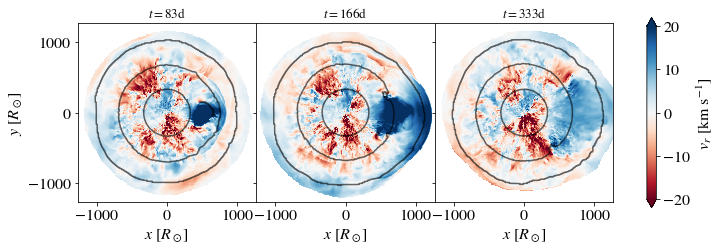

In [13]:
## SLICE FIGURE 

filelist= [base_dir+"tcc.out2.00002_slice_z0.hdf5",
           base_dir+"tcc.out2.00004_slice_z0.hdf5",
           base_dir+"tcc.out2.00008_slice_z0.hdf5"]
print(filelist)


fig,axes=plt.subplots(ncols=3,nrows=1,sharey=True,
                     figsize=(12,5))
plt.subplots_adjust(wspace=0.0)


zind=0
for i,myfile in enumerate(filelist):
    print(myfile)
    d = dd.io.load(myfile)

    ax = axes.flat[i]
    im=ax.pcolormesh(d['x1v']*RSCALE/c.rsun,d['x2v']*RSCALE/c.rsun,
                      np.where(np.log10(d['rho'][zind,:,:]*MSCALE/RSCALE**3)>-9.5,
                               d['vr'][zind,:,:]*RSCALE/TSCALE/1.e5 ,np.nan),
                 cmap='RdBu',vmin=-20,vmax=20,rasterized=True)
    ax.contour(d['x1v']*RSCALE/c.rsun,d['x2v']*RSCALE/c.rsun,
                np.log10(d['rho'][zind,:,:]*MSCALE/RSCALE**3),
                levels=[-9,-8,-7],linestyles='-',colors='k',alpha=0.6)
    ax.set_xticks([-1000,0,1000])
    ax.set_yticks([-1000,0,1000])
    ax.set_xlabel(r'$x \ [R_\odot]$')
    if i==0:
        ax.set_ylabel(r'$y \ [R_\odot]$')
    ax.set_aspect('equal')
    ax.set_title("$t=$"+str(int(np.round(d['Time']*TSCALE/86400.)))+"d",fontsize=13)
    #ph = np.linspace(0,2*np.pi,300)
    #plt.plot(8*np.cos(ph)*RSCALE/c.rsun,8*np.sin(ph)*RSCALE/c.rsun)

## ADD THE COLORBAR
cb = plt.colorbar(im,extend='both',label=r'$v_r$ [km s$^{-1}$]',ax=axes.ravel().tolist(),shrink=0.7)
cb.solids.set_edgecolor('face')
plt.savefig("figs/slice_vr.pdf",dpi=150,bbox_inches='tight')

data/P5r/tcc.out2.00002_slice_r8.hdf5
data/P5r/tcc.out2.00004_slice_r8.hdf5
data/P5r/tcc.out2.00008_slice_r8.hdf5


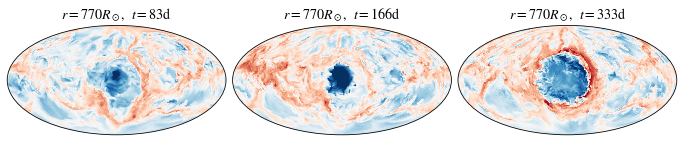

In [20]:
filelist= [base_dir+"tcc.out2.00002_slice_r8.hdf5",
           base_dir+"tcc.out2.00004_slice_r8.hdf5",
           base_dir+"tcc.out2.00008_slice_r8.hdf5"]

fig,axes=plt.subplots(ncols=3,nrows=1,
                     figsize=(12,5),subplot_kw={'projection':'aitoff'})

rad=8
nt=200
for i,myfile in enumerate(filelist):
    print(myfile)

    dr=dd.io.load(myfile)

    
    ax = axes.flat[i]
    #
    ax.pcolormesh(dr['phi'],np.pi/2-dr['theta'],dr['vr']*RSCALE/TSCALE/1.e5,cmap='RdBu',vmin=-20,vmax=20,rasterized=True)
    #plt.colorbar(extend='both',shrink=0.5,label=r'$v_r$ [km s$^{-1}$]')
    ax.set_xticks([],visible=False)
    ax.set_yticks([],visible=False)
    #plt.savefig(myfile[:-6]+'_slice_vr.png')
    #plt.close()
    ax.set_title("$r=770R_\odot$,  $t=$"+str(int(np.round(dr['time']*TSCALE/86400.)))+"d",fontsize=14)
     
    

## ADD THE COLORBAR
#cb = plt.colorbar(im,extend='both',label=r'$v_r$ [km s$^{-1}$]',ax=axes.ravel().tolist(),shrink=0.3)
#cb.solids.set_edgecolor('face')
plt.subplots_adjust(wspace=0.03)
plt.savefig("figs/slice_surf.pdf",dpi=150,bbox_inches='tight')

['data/P5r/tcc.out2.00000_ray.h5', 'data/P5r/tcc.out2.00001_ray.h5', 'data/P5r/tcc.out2.00002_ray.h5', 'data/P5r/tcc.out2.00003_ray.h5', 'data/P5r/tcc.out2.00004_ray.h5', 'data/P5r/tcc.out2.00005_ray.h5', 'data/P5r/tcc.out2.00006_ray.h5', 'data/P5r/tcc.out2.00007_ray.h5', 'data/P5r/tcc.out2.00008_ray.h5', 'data/P5r/tcc.out2.00009_ray.h5', 'data/P5r/tcc.out2.00010_ray.h5', 'data/P5r/tcc.out2.00011_ray.h5', 'data/P5r/tcc.out2.00012_ray.h5', 'data/P5r/tcc.out2.00013_ray.h5']


<ipython-input-27-1046b6729f01>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,label='time [d]')


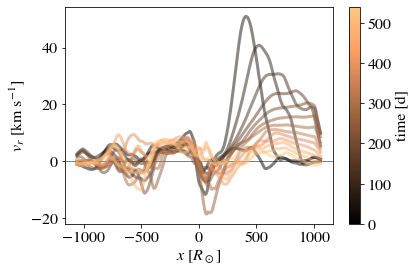

In [27]:
import glob
import deepdish as dd
from astropy.convolution import convolve, Gaussian1DKernel,Box1DKernel

gk=Box1DKernel(13.3) #Gaussian1DKernel(3)

base_dir = "data/P5r/"

filelist= sorted(glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9]_ray.h5"))[0:14:1]
tmax = dd.io.load(filelist[-1])['time']*TSCALE
print(filelist)

mycm=plt.cm.copper


plt.figure(figsize=(6,4))
plt.axhline(0,ls='-',color='grey',zorder=0,lw=1)
for i,myfile in enumerate(filelist):
    dr = dd.io.load(myfile)
    
    plt.plot(dr['x']*RSCALE/c.rsun, convolve(dr['vr']*RSCALE/TSCALE/1.e5,gk),color=mycm(dr['time']*TSCALE/tmax),
            alpha=0.5,lw=3)
    
sm = plt.cm.ScalarMappable(cmap=mycm, norm=plt.Normalize(vmin=0, vmax=tmax/86400) )
plt.colorbar(sm,label='time [d]')
plt.xlabel('$x$ [$R_\odot$]')
plt.ylabel('$v_r$ [km s$^{-1}$]')
#plt.ylim(-60,60)

plt.savefig("figs/vr_ray.pdf",bbox_inches='tight')

<ipython-input-30-51592ae79d0e>:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(vl['time_d'],vl['vlos_kms'],'-',label='$-x$',lw=3,color='DarkSalmon',zorder=1,ls='--')


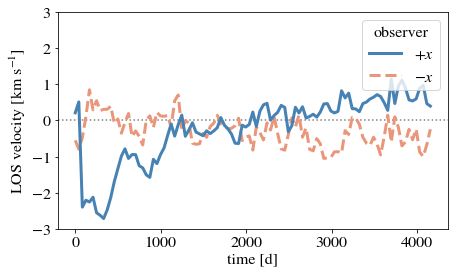

In [30]:
filelist= sorted(glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9]_slice_r8.hdf5"))

def get_vlos(n0):
    vl = []

    for i,myfile in enumerate(filelist):
        #print(i,myfile)
        dr = dd.io.load(myfile)

        dr['rvec'] = np.array([dr['x'],dr['y'],dr['z']])
        dr['rvec'] = dr['rvec']/8
        rdn = (dr['rvec'][0,:,:]*n0[0] + dr['rvec'][1,:,:]*n0[1] + dr['rvec'][2,:,:]*n0[2])

        dth = dr['theta'][0,1]-dr['theta'][0,0]
        dph = dr['phi'][1,0]-dr['phi'][0,0]
        dA = np.sin(dr['theta'])*dth*dph

        rdn_proj = np.where(rdn>0,rdn,0)

        vlos = np.sum(-dr['vr']*rdn * rdn_proj*dA) /np.sum(rdn_proj*dA) * RSCALE/TSCALE/1.e5
        vl.append( [dr['time']/86400.*TSCALE,vlos] )

    vl = Table(np.array(vl),names=['time_d','vlos_kms'])
    return vl




plt.figure(figsize=(7,4))

# observer
n0=np.array([1,0,0])
n0 = n0/np.linalg.norm(n0)

vl = get_vlos(n0)

plt.plot(vl['time_d'],vl['vlos_kms'],'-',label='$+x$',lw=3,color='SteelBlue')
#plt.xlim(0,3000)

n0=np.array([-1,0,0])
n0 = n0/np.linalg.norm(n0)

vl = get_vlos(n0)

plt.plot(vl['time_d'],vl['vlos_kms'],'-',label='$-x$',lw=3,color='DarkSalmon',zorder=1,ls='--')


plt.legend(frameon=True,title='observer',loc='upper right')


plt.axhline(0,color='grey',linestyle=':',zorder=0)
plt.xlabel('time [d]')
plt.ylabel('LOS velocity [km s$^{-1}$]')
plt.ylim(-3,3)

plt.savefig("figs/vlos.pdf",bbox_inches='tight')

In [31]:
### POWER SPECTRA FROM SURFACES 

base_dir = "data/P5r/"

filelist= sorted(glob.glob(base_dir+"tcc.out2.[0-9][0-9][0-9][0-9][0-9]_slice_r8.hdf5"))[0:50:1]
print(filelist)

times = []
spectime = []

for i,myfile in enumerate(filelist):
    print(myfile)
    dr=dd.io.load(myfile)

    gd = pyshtools.SHGrid.from_array(dr['vr'].T)
    clm = gd.expand(lmax_calc=30)

    times.append(dr['time'])
    spectime.append(clm)

datadict = {'times':times,'spectime':spectime}
dd.io.save(base_dir+"spectime_r8.hdf5",datadict)

['data/P5r/tcc.out2.00000_slice_r8.hdf5', 'data/P5r/tcc.out2.00001_slice_r8.hdf5', 'data/P5r/tcc.out2.00002_slice_r8.hdf5', 'data/P5r/tcc.out2.00003_slice_r8.hdf5', 'data/P5r/tcc.out2.00004_slice_r8.hdf5', 'data/P5r/tcc.out2.00005_slice_r8.hdf5', 'data/P5r/tcc.out2.00006_slice_r8.hdf5', 'data/P5r/tcc.out2.00007_slice_r8.hdf5', 'data/P5r/tcc.out2.00008_slice_r8.hdf5', 'data/P5r/tcc.out2.00009_slice_r8.hdf5', 'data/P5r/tcc.out2.00010_slice_r8.hdf5', 'data/P5r/tcc.out2.00011_slice_r8.hdf5', 'data/P5r/tcc.out2.00012_slice_r8.hdf5', 'data/P5r/tcc.out2.00013_slice_r8.hdf5', 'data/P5r/tcc.out2.00014_slice_r8.hdf5', 'data/P5r/tcc.out2.00015_slice_r8.hdf5', 'data/P5r/tcc.out2.00016_slice_r8.hdf5', 'data/P5r/tcc.out2.00017_slice_r8.hdf5', 'data/P5r/tcc.out2.00018_slice_r8.hdf5', 'data/P5r/tcc.out2.00019_slice_r8.hdf5', 'data/P5r/tcc.out2.00020_slice_r8.hdf5', 'data/P5r/tcc.out2.00021_slice_r8.hdf5', 'data/P5r/tcc.out2.00022_slice_r8.hdf5', 'data/P5r/tcc.out2.00023_slice_r8.hdf5', 'data/P5r/tcc.o

In [33]:
st = dd.io.load( base_dir + "spectime_r8.hdf5")

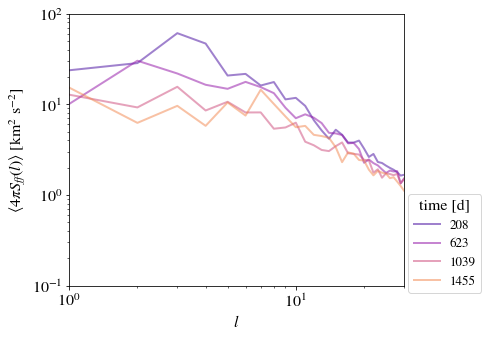

In [41]:
spec2d = []
for i in np.arange(0,len(st['spectime']),1):
    spec2d.append(4*np.pi*st['spectime'][i].spectrum()*(RSCALE/TSCALE/1.e5)**2 )
spec2d = np.array(spec2d)


iavg = 5
imax = 50
for i in np.arange(0+iavg,imax-iavg,2*iavg):
    plt.loglog(st['spectime'][i].degrees(),np.sum(spec2d[i-iavg:i+iavg+1,:],axis=0)/(2*iavg+1),
                 alpha=0.5,
                 color=plt.cm.plasma(float(i/imax)),lw=2,
                 label=int(np.round(st['times'][i]*TSCALE/86400.)))


plt.xlabel(r'$l$')
plt.ylabel(r'$\langle 4\pi S_{ff}(l) \rangle$ [km$^2$ s$^{-2}$]')
plt.xlim(1,st['spectime'][0].degrees()[-1])
plt.ylim(1e-1,100)
plt.legend(title='time [d]',loc='lower right',bbox_to_anchor=(1.25,-0.05),fontsize=13)
plt.savefig("figs/spec1d.pdf",bbox_inches='tight')

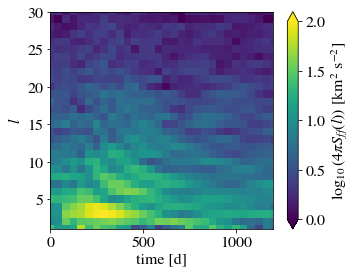

In [42]:
plt.figure(figsize=(5,4))
plt.pcolormesh(np.array(st['times'])*TSCALE/86400.,st['spectime'][0].degrees(), np.log10(spec2d.T),
              vmin=0.,vmax=2,rasterized=True)

plt.colorbar(extend='both',label=r'$\log_{10}(4\pi S_{ff}(l))$ [km$^2$ s$^{-2}$]')
plt.xlabel('time [d]')
plt.ylabel('$l$')
plt.xlim(0,1200)
plt.ylim(1,30)
#plt.semilogy()

plt.savefig("figs/spec2d.pdf",bbox_inches='tight')

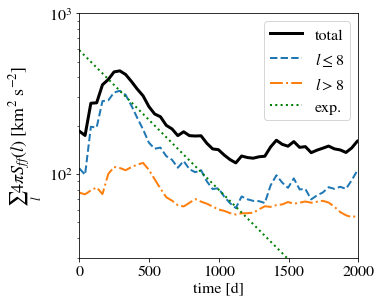

In [48]:
td = np.array(st['times'])*TSCALE/86400.
lcut = 8

plt.figure(figsize=(5,4.5))

plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=3)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=2)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=2)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1)[7]*np.exp(-(td-td[7])/(500)),':',color='green' ,label='exp.' ,lw=2)

plt.legend(loc='upper right')

plt.xlim(0,2000)
plt.xlabel('time [d]')
plt.ylabel(r'$\sum_l 4\pi S_{ff}(l) $ [km$^2$ s$^{-2}$]',fontsize=18)
plt.ylim(30,1000)
plt.savefig("figs/power.pdf",bbox_inches='tight')

In [55]:
# predicted dissipation rate
lstar =  LmodelEplus*MSCALE*RSCALE**2 / TSCALE**3
print("lstar/lsun=",lstar/3.84e33)

gamma_est = (lstar/(mstar*rstar**2))**(1/3) 
print('diss time =',1/gamma_est/86400.,'d')


lstar/lsun= 235121.34975717432
diss time = 556.7506266002463 d


In [56]:
bgnad = pg.read_output("gyre/summary_nad_nr.txt")
bgnad['P_d'] = 2*np.pi/np.real(bgnad['omega']) * np.sqrt(bgnad['R_star']**3/(c.G*bgnad['M_star'])) / 86400.

print(bgnad.keys())

gt = bgnad[['l','n_p','n_pg','omega','P_d','eta','W']]
gt['Re(omega)'] = np.round(np.real(gt['omega']),3)
gt['Im(omega)'] = np.round(np.imag(gt['omega']),3)
gt['P_d'] = np.round(np.real(gt['P_d']),1)
gt['eta'] = np.round(gt['eta'],2)

sel = gt['n_pg']<=3


gt[sel]

['E', 'E_norm', 'H', 'L_star', 'M_star', 'Omega_rot_ref', 'R_star', 'W', 'eta', 'l', 'm', 'n_g', 'n_p', 'n_pg', 'freq', 'omega', 'P_d']


l,n_p,n_pg,omega,P_d,eta,W,Re(omega),Im(omega)
int64,int64,int64,complex128,float64,float64,float64,float64,float64
0,1,1,(1.456731640758321+0.007046147544748985j),405.7,0.36,0.06440080928507609,1.457,0.007
0,2,2,(3.103720479990962+0.01746773524480468j),190.4,0.53,0.339238895541157,3.104,0.017
0,3,3,(4.915383650573435+0.04405396467620957j),120.2,0.74,1.352273255292434,4.915,0.044
1,0,1,(1.09109128517639+0.001618807403048281j),541.6,0.4,0.01100310861401506,1.091,0.002
1,1,2,(2.468133288415159+0.01159493327696137j),239.4,0.47,0.1794176759056232,2.468,0.012
1,2,3,(4.225247059143618+0.02908448125980057j),139.9,0.66,0.7679522503755148,4.225,0.029
2,0,0,(1.560811224881652+0.001026628229776529j),378.6,0.35,0.01004375174672014,1.561,0.001
2,1,1,(3.01981270112973+0.01298047906715531j),195.7,0.49,0.245425075174931,3.02,0.013
2,2,2,(4.827230498278525+0.03949536466519118j),122.4,0.72,1.191203768650353,4.827,0.039


In [57]:
ascii.write(gt[sel],format='latex')

\begin{table}
\begin{tabular}{ccccccccc}
l & n_p & n_pg & omega & P_d & eta & W & Re(omega) & Im(omega) \\
0 & 1 & 1 & (1.456731640758321+0.007046147544748985j) & 405.7 & 0.36 & 0.06440080928507609 & 1.457 & 0.007 \\
0 & 2 & 2 & (3.103720479990962+0.01746773524480468j) & 190.4 & 0.53 & 0.339238895541157 & 3.104 & 0.017 \\
0 & 3 & 3 & (4.915383650573435+0.04405396467620957j) & 120.2 & 0.74 & 1.352273255292434 & 4.915 & 0.044 \\
1 & 0 & 1 & (1.09109128517639+0.001618807403048281j) & 541.6 & 0.4 & 0.01100310861401506 & 1.091 & 0.002 \\
1 & 1 & 2 & (2.468133288415159+0.01159493327696137j) & 239.4 & 0.47 & 0.1794176759056232 & 2.468 & 0.012 \\
1 & 2 & 3 & (4.225247059143618+0.02908448125980057j) & 139.9 & 0.66 & 0.7679522503755148 & 4.225 & 0.029 \\
2 & 0 & 0 & (1.560811224881652+0.001026628229776529j) & 378.6 & 0.35 & 0.01004375174672014 & 1.561 & 0.001 \\
2 & 1 & 1 & (3.01981270112973+0.01298047906715531j) & 195.7 & 0.49 & 0.245425075174931 & 3.02 & 0.013 \\
2 & 2 & 2 & (4.827230498278525

In [567]:
## NOTE: including this code for completeness, but these data are not included in the github! 

st5 = dd.io.load("/Volumes/LaCie/turb/P5/spectime.hdf5")
st5r = dd.io.load("/Volumes/LaCie/turb/P5r/spectime.hdf5")
st5c = dd.io.load("/Volumes/LaCie/turb/P5c/spectime.hdf5")
times=st5c['times']

def getspec2d(st):
    spec2d = []
    for i in np.arange(0,len(st['spectime']),1):
        spec2d.append(4*np.pi*st['spectime'][i][ri].spectrum()*(RSCALE/TSCALE/1.e5)**2 )
    spec2d = np.array(spec2d)
    return spec2d

In [626]:
hstc = ascii.read("/Volumes/LaCie/turb/P5c/tcc.hst",header_start=1)
print( hstc.keys() )

rphc = 6
MSCALEc = mstar/hstc['[22]=M_r'][0]
RSCALEc = rstar/rphc
TSCALEc = np.sqrt(rstar**3/(c.G*mstar))/np.sqrt(rphc**3/1)


print(MSCALE,RSCALE,TSCALE)
print(MSCALEc,RSCALEc,TSCALEc)

['[1]=time', '[2]=dt', '[3]=mass', '[4]=1-mom', '[5]=2-mom', '[6]=3-mom', '[7]=1-KE', '[8]=2-KE', '[9]=3-KE', '[10]=tot-E', '[11]=jx-tot', '[12]=jy-tot', '[13]=jz-tot', '[14]=mdot-1', '[15]=jxdot-1', '[16]=jydot-1', '[17]=jzdot-1', '[18]=mdot-2', '[19]=jxdot-2', '[20]=jydot-2', '[21]=jzdot-2', '[22]=M_r', '[23]=Ek_r', '[24]=Eth_r', '[25]=Eg_r', '[26]=Etot_r']
3.7582197147616902e+22 6701413953548.216 359120.0634245879
3.574317271286453e+22 8935218604730.955 552901.5074388835


r= 8


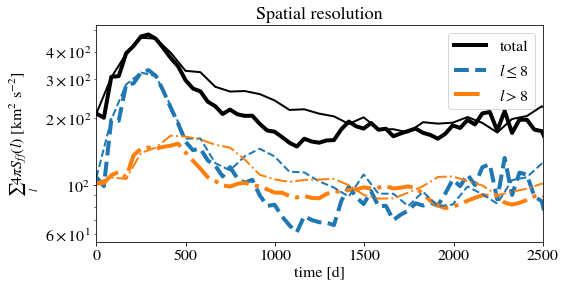

In [645]:
ri = 3

lcut = 8



plt.figure(figsize=(8,4))

spec2d = getspec2d(st5r)
print("r=",st5r['radii'][ri])
td = np.array(st5r['times'])*TSCALE/86400.
plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=4)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=4)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=4)
#plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1)[2]*np.exp(-(td-td[2])/(734)),':',color='green' ,label='exp.' )

plt.legend(loc='upper right')

spec2d = getspec2d(st5)
td = np.array(st5['times'])*TSCALE/86400.
plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=2)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=2)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=2)

"""
ri = 1
print("r=",st5c['radii'][ri])
spec2d = getspec2d(st5c) * (RSCALEc/TSCALEc/1.e5)**2/(RSCALE/TSCALE/1.e5)**2
td = np.array(st5c['times'])*TSCALEc/86400.
plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=1)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=1)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=1)
"""
plt.xlim(0,2500)
#plt.ylim(60,)
plt.xlabel('time [d]')
plt.title("Spatial resolution",fontsize=18)
plt.ylabel(r'$\sum_l 4\pi S_{ff}(l) $ [km$^2$ s$^{-2}$]')
plt.savefig('figs/resolution.pdf',bbox_inches='tight')

r= 8
r= 6


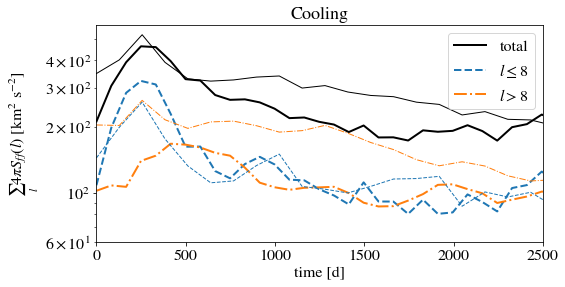

In [646]:
lcut = 8




plt.figure(figsize=(8,4))

ri = 3
print("r=",st5['radii'][ri])
spec2d = getspec2d(st5)
td = np.array(st5['times'])*TSCALE/86400.
plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=2)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=2)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=2)
#plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1)[2]*np.exp(-(td-td[2])/(734)),':',color='green' ,label='exp.' )

plt.legend(loc='upper right')

ri = 1
print("r=",st5c['radii'][ri])
spec2d = getspec2d(st5c) * (RSCALEc/TSCALEc/1.e5)**2/(RSCALE/TSCALE/1.e5)**2
td = np.array(st5c['times'])*TSCALEc/86400.
plt.semilogy(td,np.sum(spec2d,axis=1),'k-' ,label='total',lw=1)
plt.semilogy(td,np.sum(spec2d[:,0:lcut+1],axis=1),'C0--' ,label=r'$l\leq$'+str(lcut),lw=1)
plt.semilogy(td,np.sum(spec2d[:,lcut+1:],axis=1),'C1-.' ,label=r'$l>$'+str(lcut),lw=1)

plt.xlim(0,2500)
plt.ylim(60,)
plt.xlabel('time [d]')
plt.ylabel(r'$\sum_l 4\pi S_{ff}(l) $ [km$^2$ s$^{-2}$]')
plt.title("Cooling",fontsize=18)
plt.savefig('figs/cooling.pdf',bbox_inches='tight')

7

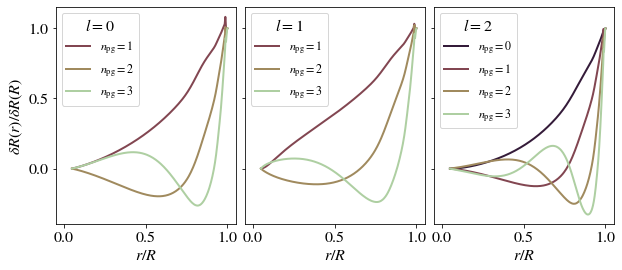

In [58]:
import seaborn as sns
import pygyre as pg


mycm = sns.cubehelix_palette(n_colors=4,start=0,rot=0.8,light=0.75,as_cmap=True,reverse=True)
plt.subplots(ncols=3,sharey=True,figsize=(10,4))

# l=0
plt.subplot(131)
filelist = ["gyre/mode.000_+00_+00001.txt",
           "gyre/mode.000_+00_+00002.txt",
           "gyre/mode.000_+00_+00003.txt"]

for i,fn in enumerate(filelist):
    mode = pg.read_output(fn)
    plt.plot(mode['x'],mode['xi_r']/mode['xi_r'][-1],lw=2,label=r"$n_{\rm pg}=$"+fn[-5:-4],
             color=mycm( (i+1)/3 ) )
    
plt.xlim(-0.05,1.05)
plt.legend(title="$l=0$",frameon=True,fontsize=12)
plt.xlabel('$r/R$')
plt.ylabel('$\delta R(r) / \delta R(R)$')

# l=1
plt.subplot(132)
filelist = ["gyre/mode.001_+00_+00001.txt",
           "gyre/mode.001_+00_+00002.txt",
           "gyre/mode.001_+00_+00003.txt"]

for i,fn in enumerate(filelist):
    mode = pg.read_output(fn)
    plt.plot(mode['x'],mode['xi_r']/mode['xi_r'][-1],lw=2,label=r"$n_{\rm pg}=$"+fn[-5:-4],
             color=mycm( (i+1)/3) )
plt.xlim(-0.05,1.05)
plt.legend(title="$l=1$",frameon=True,fontsize=12)
plt.xlabel('$r/R$')

# l=2
plt.subplot(133)
filelist = ["gyre/mode.002_+00_+00000.txt",
           "gyre/mode.002_+00_+00001.txt",
           "gyre/mode.002_+00_+00002.txt",
           "gyre/mode.002_+00_+00003.txt"]

for i,fn in enumerate(filelist):
    mode = pg.read_output(fn)
    plt.plot(mode['x'],mode['xi_r']/mode['xi_r'][-1],lw=2,label=r"$n_{\rm pg}=$"+fn[-5:-4],
             color=mycm( i/3) )
plt.xlim(-0.05,1.05)
plt.legend(title="$l=2$",frameon=True,fontsize=12)
plt.xlabel('$r/R$')
#plt.ylabel('$\delta R(r) / \delta R(R)$')



#plt.ylabel('$\delta R(r) / \delta R(R)$')

plt.subplots_adjust(wspace=0.05)
plt.savefig("figs/eigenfuncs.pdf",bbox_inches='tight')